In [1]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import datetime

start_time = time.time()


In [2]:
#---------------- constants --------------------
r0 = np.array([0, 0, 2]).T      # starting height (m)
g = np.array([0, 0, -9.81]).T   # gravity (m/s^2)

# r0 = np.array([0, 2, 0]).T      # starting height (m)
# g = np.array([0, -9.81, 0]).T   # gravity (m/s^2)

t_tot = .25                        # simulation time (s)
dt = 1e-4                       # time step (s)
V0 = 30                         # magnitude of cough velocity (m / s)
rho = 1000                      # density of particles (kg / m^3)
mTot = 0.00005                   # total mass of droplets (kg)

vf = np.array([0, 0, 0]).T      # surrounding fluid velocity (m/s)
muf = 1.8e-5                    # surrounding fluid viscosity (Pa/s)
rhoF = 1.225                    # density of air (kg / m^3)

In [3]:
#---------------- particle generation --------------------
R_ave = 0.0001                  # average particle radius (m)
R = []                          # vector containing particle radii
Mtot = 0                        # track total number of particles
mi = []                         # mass of each particle (kg)
Aci = []                        # cross sectional area of each particle (m^2)
A = 0.9975                      # deviatiatoric constant
i = 0                           # index
counter = True                  # counter

while counter:
    xi = np.random.randint(low=-1000, high=1000, size=1)/1000;
    R.append(R_ave * (1 + A * xi))
    Mtot = Mtot + rho*(4/3)*np.pi*R[i]**3
    mi.append(rho*(4/3)*np.pi*R[i]**3)
    Aci.append(np.pi * R[i]**2)
    if Mtot >= mTot:
        counter = False
        pTot = i + 1
        print('Total # particles = ', pTot)
        print('rMin = ', np.amin(R))
        print('rMax = ', np.amax(R))
    else:
        i += 1
        

Aci = np.asarray(Aci)
R = np.asarray(R).T
mi = np.asarray(mi)

np.random.seed(10)
sample = np.random.choice(pTot, 1000, replace=False)     # select random particles to plot


Total # particles =  5876
rMin =  2.499999999999947e-07
rMax =  0.00019965025


In [5]:
# initial trajectories
Nc = np.array([0, 1., 0]).T     # direction of cough [x, y, z]
NPart = np.zeros((pTot, 3))     # perturbed direction for each particle [xi, yi, zi]
nPart = np.zeros((pTot, 3))     # normalized vector for each particle [nx, ny, nz]
Ac = np.array([1.0, 0.5, 1.]).T  # deviatoric constants [Ax, Ay, Az]


for i in range(pTot):
    eta = [np.random.randint(low=-1000, high=1000, size=1)/1000,
           np.random.randint(low=0, high=1000, size=1)/1000,
           np.random.randint(low=-1000, high=1000, size=1)/1000]

    NPart[i, 0] = Nc[0] + Ac[0]*eta[0]
    NPart[i, 1] = Nc[1] + Ac[1]*eta[1]
    NPart[i, 2] = Nc[2] + Ac[2]*eta[2]

    nMag = np.linalg.norm(NPart[i, :], 2)

    nPart[i, 0] = NPart[i, 0] / nMag
    nPart[i, 1] = NPart[i, 1] / nMag
    nPart[i, 2] = NPart[i, 2] / nMag

v0 = V0 * nPart

vi =  (5876, 3)
i =  0
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  1
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  2
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  3
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  4
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  5
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  6
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  7
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  8
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  9
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  10
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  11
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  12
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  13
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  14
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  15
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i 

i =  151
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  152
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  153
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  154
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  155
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  156
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  157
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  158
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  159
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  160
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  161
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  162
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  163
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  164
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  165
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  166
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5

shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  284
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  285
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  286
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  287
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  288
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  289
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  290
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  291
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  292
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  293
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  294
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  295
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  296
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  297
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  298
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i

shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  415
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  416
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  417
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  418
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  419
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  420
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  421
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  422
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  423
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  424
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  425
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  426
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  427
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  428
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  429
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i

shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  548
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  549
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  550
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  551
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  552
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  553
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  554
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  555
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  556
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  557
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  558
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  559
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  560
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  561
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  562
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i

i =  691
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  692
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  693
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  694
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  695
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  696
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  697
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  698
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  699
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  700
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  701
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  702
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  703
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  704
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  705
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5876, 3)
i =  706
shape  (5876,)
fDrag =  (5876, 3)
fDrag2 =  (5

KeyboardInterrupt: 

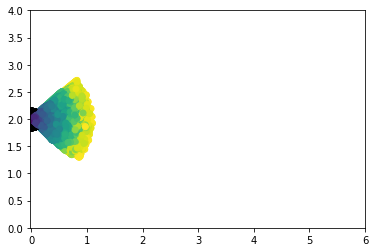

In [17]:
from celluloid import Camera
#---------------- solution arrays --------------------
v0 = V0 * nPart
rSol = []
time_arr = []
fig = plt.figure()
camera = Camera(fig)
plot_R = R[0,sample]
# ---------------------------------------------
# ----------- Begin time stepping -------------
# ---------------------------------------------

ones = np.ones(pTot)
vi = v0
ri = np.outer(r0, ones).T
rSol.append(ri)
fGrav = np.outer(mi, g)

inAir = np.ones(len(ri[:,0]), dtype=bool)
timeFlight = np.zeros(len(inAir))

t_step = 0
time_arr.append(t_step)
i = 0
print('vi = ', vi.shape)
while np.any(inAir):
    print('i = ', i)
    if t_step > t_tot:
        print("simulation finished")
        break

    Cd = np.zeros(pTot)
    
    # compute forces
    vdiff = np.linalg.norm(vf - vi, 2, 1)

    Re = (2 * R * rhoF * vdiff / muf).T
    cond1 = np.where(np.logical_and(Re > 0, Re <= 1.0))[0]
    cond2 = np.where(np.logical_and(Re > 1.0, Re <= 400))[0]
    cond3 = np.where(np.logical_and(Re > 400, Re <= 3e5))[0]
    cond4 = np.where(np.logical_and(Re > 3e5, Re <= 2e6))[0]
    cond5 = np.where(np.logical_and(Re > 2e6, Re > 1.0))[0]
        
    if len(cond1) > 0:
        Cd[cond1] = 24. / np.squeeze(Re[cond1])
    if len(cond2) > 0:
        Cd[cond2] = 24. / np.squeeze(np.power(Re[cond2], 0.646))
    if len(cond3) > 0:
        Cd[cond3] = 0.5
    if len(cond4) > 0:
        Cd[cond4] = 0.000366 * np.squeeze(np.power(Re[cond4], 0.4275))
    if len(cond5) > 0:
        Cd[cond5] = 0.18

#     Cd = np.reshape(Cd, (len(Cd), 1))
#     vdiff = np.reshape(Cd, (len(vdiff), 1))
    
    # https://stackoverflow.com/questions/18522216/multiplying-across-in-a-numpy-array
#     fDrag_constant = np.squeeze(Cd[inAir] * rhoF * Aci * vdiff)
    print('shape ', (vdiff).shape)
    dragC = np.array([(Cd * np.squeeze(Aci) * vdiff), 
                      (Cd * np.squeeze(Aci) * vdiff), 
                      (Cd * np.squeeze(Aci) * vdiff)]).T
    fDrag = 1/2 * rhoF * dragC * (vf - vi)
    print('fDrag = ', dragC.shape)
    print('fDrag2 = ', (vf - vi).shape)
    fTot = fDrag + fGrav

#     if i < 3:
#         print('fDrag = ', fDrag[0:6,:])
#         print('fGrav = ', fGrav[0:6,:])
#         print('fTot = ', fTot[0:6,:])
#         print('v = ', vi[0:6,:])
#         print('')
    

    ri[inAir,:] = ri[inAir,:] + dt*vi[inAir,:]
    vi[inAir,:] = vi[inAir,:] + dt*(fTot[inAir,:] / mi[inAir])

    contactSubstrate = np.where(ri[:, 2] <= 0)
    inAir[contactSubstrate] = False
    ri[contactSubstrate, 2] = 0

    # animate
    if i % 10 == 0:
        x2d = ri[sample,1]
        y2d = ri[sample,2]
        plt.scatter(r0[1], r0[2], color='k', s=500)
        plt.scatter(x2d, y2d, c=plot_R, cmap='viridis')
        plt.xlim(-0.02, 6)
        plt.ylim(0, 4)
        camera.snap()
        
        
    rSol.append(ri)

        
    t_step += dt
    time_arr.append(t_step)
    i += 1
      

# --------------------------------------------
print('compiling video ...')
animation = camera.animate()
animation.save('animation.mp4')
print('____ compile complete ____')


In [ ]:
# # find furthest particle in x direction
# xMax = np.max(rSol[-1][:,0])
# print('furthest particle in x-direction = ', xMax)
# zMax = np.max(rSol[-1][:,2])
# print('furthest particle in z-direction = ', zMax)
# yMax = np.min(rSol[-1][:,1])
# print('furthest particle in y-direction = ', yMax)

# print('finalSol.shape: ', finalSol.shape)
# np.random.seed(10)
# sample = np.random.choice(pTot, 1000, replace=False)     # select random particles to plot
# plot_sol = finalSol[sample, :]
# plot_R = R[0,sample]

# fig = plt.figure(figsize = (10, 7))
# ax = plt.axes(projection='3d')

# ax.scatter3D(r0[0], r0[1], r0[2], c='k', marker='o', s=500)
# output_fig = ax.scatter3D(plot_sol[:, 0], plot_sol[:, 1], plot_sol[:, 2], 
#                           marker='o', s=50, c=plot_R)
# cbar = plt.colorbar(output_fig)
# cbar.set_label('Particle radius (m)')
# ax.set_title('Cough at time = {}s'.format(t_tot),y = 1.08)
# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')
# ax.set_xlim(-0.02, 6)
# ax.set_ylim(0, 6)
# ax.set_zlim(-0.2, 6)
# ax.view_init(180,45)
# plt.savefig('cough.png')